<a href="https://colab.research.google.com/github/ETSlime/GoogleColab/blob/IVC/IVC_miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install dlib

     |████████████████████████████████| 7.4 MB 4.2 MB/s 
  Created wheel for dlib: filename=dlib-19.22.1-cp37-cp37m-linux_x86_64.whl size=4331364 sha256=24660a0cd26e5b4bee4cc11c15d91818d5222a05e4ab77bc692ee154a01f8f0c
  Stored in directory: /root/.cache/pip/wheels/10/6f/db/ef0380a66d955f9caa81cff6027fb77c0b556568e0daace292
Successfully built dlib


In [ ]:
pwd

'/content'

In [ ]:
cd drive/My Drive/IVC

/content/drive/My Drive/IVC


# Import the modules

In [ ]:
#general import
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import copy
import pandas as pd
from time import time
from google.colab import files
from datapath_utils import get_image_paths
#SVM
import cv2
import dlib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import preprocessing
from skimage.feature import hog
from skimage import data, exposure
from utils import read_img, resize_img, rgb_to_gray
#Resnet
import torch
import torch.nn as nn
from PIL import Image
from torchvision import datasets, models, transforms

# Load dataset

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
!unzip dataset.zip

In [ ]:
DATA_PATH = 'dataset'
IMAGE_CATEGORIES = [
    'angry','disgust','fear',
    'happy','neutral','sad','surprise'
]
train_image_paths, test_image_paths, train_labels, test_labels =\
    get_image_paths(DATA_PATH, IMAGE_CATEGORIES)

In [ ]:
train_image_paths, validation_image_paths, train_labels, validation_labels = train_test_split(
    train_image_paths, train_labels, train_size = 0.75, test_size=0.25, random_state=0)

In [ ]:
len(train_image_paths)

21531

In [ ]:
#read one image to see its size
img = cv2.imread(train_image_paths[0])
img.shape

(48, 48, 3)

In [ ]:
shape_x = img.shape[0]
shape_y = img.shape[1]

In [ ]:
def load_img(img_path, step = 1000):
  image_features = []
  begin = 0
  end = 0
  n = math.floor(len(img_path)/step)
  for i in range(n):
   end = end + step
   start_time = time()
   for j in range(begin, end):
     img = read_img(img_path[j])
     image_features.append(img.flatten())
   training_time = time() - start_time
   #print("Number of image read : ", end)
   #print("Time per 1000 image : ", training_time)
   begin = begin + step
  for i in range(end, len(img_path)):
    img = read_img(img_path[j])
    image_features.append(img.flatten())
  return np.asarray(image_features)

In [ ]:
train_images = load_img(train_image_paths)
validation_images = load_img(validation_image_paths)
test_images = load_img(test_image_paths)

In [ ]:
np.save('train_images.npy', train_images)
np.save('validation_images.npy', validation_images)
np.save('test_images.npy', test_images)

In [ ]:
train_images = np.load('train_images.npy')
validation_images = np.load('validation_images.npy')
test_images = np.load('test_images.npy')

In [ ]:
print("Number of train image: ", train_images.shape[0])
print("Number of validation image: ", validation_images.shape[0])
print("Number of test image: ", test_images.shape[0])

Number of train image:  21531
Number of validation image:  7178
Number of test image:  7178


# ResNet-18

In [ ]:
train_images = np.load('/content/drive/MyDrive/IVC/resnet train data/Training.npy')
validation_images = np.load('/content/drive/MyDrive/IVC/resnet train data/Validation.npy')
test_images = np.load('/content/drive/MyDrive/IVC/resnet train data/PublicTest.npy')

In [ ]:
print("Number of train image: ", train_images.shape[0])
print("Number of validation image: ", validation_images.shape[0])
print("Number of test image: ", test_images.shape[0])

In [ ]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

In [ ]:
le = preprocessing.LabelEncoder()
# encode target labels
train_labels_encode = le.fit(train_labels)
train_labels_encode = train_labels_encode.transform(train_labels)

validation_labels_encode = le.fit(validation_labels)
validation_labels_encode = validation_labels_encode.transform(validation_labels)

test_labels_encode = le.fit(test_labels)
test_labels_encode = test_labels_encode.transform(test_labels)

In [ ]:
np.save('Training_labels.npy', train_labels_encode)
np.save('Validation_labels.npy', validation_labels_encode)
np.save('PublicTest_labels.npy', test_labels_encode)

In [ ]:
train_labels_encode = np.load('/content/drive/MyDrive/IVC/resnet train data/Training_labels.npy')
validation_labels_encode = np.load('/content/drive/MyDrive/IVC/resnet train data/Validation_labels.npy')
test_labels_encode = np.load('/content/drive/MyDrive/IVC/resnet train data/PublicTest_labels.npy')

In [ ]:
def eval_model(model, data_loader, criterion):
    model.eval()
    with torch.no_grad():
        accuracy = 0
        loss = 0
        for data, labels in data_loader:
            output = model(data)
            _, preds = torch.max(output.data, 1)
            equals = (preds == labels).cpu()
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            loss += criterion(output, labels).data.cpu()
        return accuracy/len(data_loader), loss/len(data_loader)
        
def train_model(model, criterion, optimizer, data_loader, eval_loader, epochs=100):
    model = model.to(device)
    test_accuracy_history = []
    test_loss_history = []
    
    for epoch in range(epochs):
        start_time = time()
        model.train()
        for data, labels in data_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
        training_time = time() - start_time
        #print('Number of epoch: ', epoch)
        #print('Training time per epoch: ', training_time)
            
        accuracy, loss = eval_model(model, eval_loader, criterion)
        #print('Accuracy: ', accuracy)
        test_accuracy_history.append(accuracy)
        test_loss_history.append(loss)
    return test_accuracy_history, test_loss_history

In [ ]:
def make_dataloader(data, labels, batch_size, shuffle):
    images = data / 255.0
    images = torch.FloatTensor(images.reshape(images.shape[0], 1, 48, 48)).to(device) # 1 color channel, 48x48 images
    dataset = torch.utils.data.TensorDataset(images, torch.LongTensor(np.array(labels)).to(device))
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
#fine-tune
fc_features = model.fc.in_features
model.fc = nn.Linear(fc_features, len(IMAGE_CATEGORIES))
model.conv1= nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3),bias=False)

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
train_loader = make_dataloader(train_images, train_labels_encode, 100, True)
valid_loader = make_dataloader(validation_images, validation_labels_encode, 100, False)
test_loader = make_dataloader(test_images, test_labels_encode, 100, False)

In [ ]:
accuracy, loss = train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=1)

In [ ]:
torch.save(model, 'ResNet18_model.pt')

In [ ]:
accuracy, loss = eval_model(model, test_loader, criterion)
accuracy

In [ ]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
accuracy_test = []
for lr in lr:
  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
  model.fc = nn.Linear(fc_features, len(IMAGE_CATEGORIES))
  model.conv1= nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3),bias=False)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  model = model.to(device)
  train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=100)
  accuracy, loss = eval_model(model, test_loader, criterion)
  print("Accuracy for lr=%f : %f" %(lr,accuracy))
  accuracy_test.append(accuracy)
  

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, log_loss

baselines = ['uniform', 'most_frequent']
fig, ax = plt.subplots(len(baselines), 1, figsize=(5.5,6))
bl_loss = {}

plt.savefig("Resnet.pdf")
for ii, baseline in enumerate(baselines):
    category = []
    plt.sca(ax[ii])
    dummy_classifier = DummyClassifier(strategy=baseline).fit(test_images, test_labels_encode)
    pred_proba = dummy_classifier.predict_proba(test_images)
    for i in range(pred_proba.shape[0]):
      category.append(np.random.choice(np.arange(pred_proba[i].size),p=pred_proba[i]))
    equals = (category == test_labels_encode)
    acc = equals.sum()/len(test_labels_encode)

    plt.axhline(acc, label='{} baseline'.format(baseline), linestyle='--')
    plt.scatter(lr, accuracy)
    plt.xscale('log')
    plt.xlabel('learning rate')
    plt.ylabel('Accuracy on validation set')
    plt.legend()
plt.savefig("Resnet.pdf")
plt.suptitle('Facial expression classification')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("Resnet.pdf")
plt.show()

# Robustness exploration

In [ ]:
model = torch.load('ResNet18_model.pt')

Gaussian pixel noise

In [ ]:
num_of_test = 10
accuracy_pixel_noise = []
for i in range(num_of_test):
  path = os.path.join('/content/drive/MyDrive/IVC/test data/Gaussian pixel noise/ResNet/Gaussian_noise_'+str(i*2)+'.npy')
  gaussian_noise_image = np.load(path)
  test_loader = make_dataloader(gaussian_noise_image, test_labels_encode, 100, True)
  accuracy, loss = eval_model(model, test_loader, criterion)
  accuracy_pixel_noise.append(accuracy)

In [ ]:
accuracy_pixel_noise

[0.5725783473915524,
 0.5719622468782796,
 0.5703133857912488,
 0.5707158111035824,
 0.5678739291098382,
 0.5633689446581734,
 0.55249999753303,
 0.5487286307745509,
 0.5405947272148397,
 0.5337499980297353]

In [ ]:
np.save('accuracy_pixel_noise.npy',accuracy_pixel_noise)

Gaussian blurring

In [ ]:
num_of_test = 10
accuracy_gaussiong_blurring = []
for i in range(num_of_test):
  path = os.path.join('/content/drive/MyDrive/IVC/test data/Gaussian blurring/ResNet/Gaussian_blurring_'+str(i)+'.npy')
  gaussian_blurring = np.load(path)
  test_loader = make_dataloader(gaussian_blurring, test_labels_encode, 100, True)
  accuracy, loss = eval_model(model, test_loader, criterion)
  accuracy_gaussiong_blurring.append(accuracy)

In [ ]:
accuracy_gaussiong_blurring

[0.5727742136352592,
 0.5463853292167187,
 0.5045049807263745,
 0.43821581163340145,
 0.4106588280863232,
 0.38075854691366356,
 0.3554807708909114,
 0.33177350730531746,
 0.31532407572699916,
 0.3023290615528822]

In [ ]:
np.save('accuracy_gaussiong_blurring.npy',accuracy_gaussiong_blurring)

Image Brightness Decrease

In [ ]:
num_of_test = 10
accuracy_brightness_decrease = []
for i in range(num_of_test):
  path = os.path.join('/content/drive/MyDrive/IVC/test data/Image Brightness Decrease/ResNet/Image_Brightness_-'+str(i*5)+'.npy')
  brightness_decrease = np.load(path)
  test_loader = make_dataloader(brightness_decrease, test_labels_encode, 100, True)
  accuracy, loss = eval_model(model, test_loader, criterion)
  accuracy_brightness_decrease.append(accuracy)

In [ ]:
accuracy_brightness_decrease

[0.5726175213025676,
 0.5733119654986594,
 0.5709472931921482,
 0.5718803397483296,
 0.5667022752265135,
 0.564419514603085,
 0.5608084040383498,
 0.5574572620292505,
 0.5498183717330297,
 0.543511390272114]

In [ ]:
np.save('accuracy_brightness_decrease.npy',accuracy_brightness_decrease)

Image Brightness Increase

In [ ]:
num_of_test = 10
accuracy_brightness_increase = []
for i in range(num_of_test):
  path = os.path.join('/content/drive/MyDrive/IVC/test data/Image Brightness Increase/ResNet/Image_Brightness_'+str(i*5)+'.npy')
  brightness_increase = np.load(path)
  test_loader = make_dataloader(brightness_increase, test_labels_encode, 100, True)
  accuracy, loss = eval_model(model, test_loader, criterion)
  accuracy_brightness_increase.append(accuracy)

In [ ]:
accuracy_brightness_increase

[0.5729309084514776,
 0.5719017059438758,
 0.5688283468286196,
 0.5650997145308388,
 0.5669800543950664,
 0.5622400293747584,
 0.5600997143321567,
 0.5536858960986137,
 0.5469230736295382,
 0.538368941595157]

In [ ]:
np.save('accuracy_brightness_increase.npy',accuracy_brightness_increase)

Image Contrast Decrease

In [ ]:
num_of_test = 10
accuracy_contrast_decrease = []
for i in range(num_of_test):
  path = os.path.join('/content/drive/MyDrive/IVC/test data/Image Contrast Decrease/ResNet/Image_Contrast_'+str(round(1.1-(i+1)*0.1,2))+'.npy')
  contrast_decrease = np.load(path)
  test_loader = make_dataloader(contrast_decrease, test_labels_encode, 100, True)
  accuracy, loss = eval_model(model, test_loader, criterion)
  accuracy_contrast_decrease.append(accuracy)

In [ ]:
accuracy_contrast_decrease

[0.5726566943857405,
 0.5702564083039761,
 0.556862533920341,
 0.5433084016872777,
 0.5164672318432066,
 0.4842272036605411,
 0.40305911459856564,
 0.3267521384275622,
 0.21534900243083635,
 0.13281339106874335]

In [ ]:
np.save('accuracy_contrast_decrease.npy',accuracy_contrast_decrease)

Image Contrast Increase

In [ ]:
num_of_test = 10
accuracy_contrast_increase = []
for i in range(num_of_test):
  path = os.path.join('/content/drive/MyDrive/IVC/test data/Image Contrast Increase/ResNet/Image_Contrast_'+str(1+i*0.03)+'.npy')
  contrast_increase = np.load(path)
  test_loader = make_dataloader(contrast_increase, test_labels_encode, 100, True)
  accuracy, loss = eval_model(model, test_loader, criterion)
  accuracy_contrast_increase.append(accuracy)

In [ ]:
accuracy_contrast_increase

[0.5729309059679508,
 0.5727528445422649,
 0.5692022736701701,
 0.5667058395014869,
 0.5652955840859148,
 0.5637250691652298,
 0.5612464377449619,
 0.5569230752686659,
 0.5520014216502508,
 0.54666310424606]

In [ ]:
np.save('accuracy_contrast_increase.npy',accuracy_contrast_increase)

Occlusion of the Image Increase

In [ ]:
num_of_test = 10
accuracy_occlusion = []
for i in range(num_of_test):
  path = os.path.join('/content/drive/MyDrive/IVC/test data/Occlusion of the Image Increase/ResNet/Occlusion_'+str(i*5)+'.npy')
  occlusion = np.load(path)
  test_loader = make_dataloader(occlusion, test_labels_encode, 100, True)
  accuracy, loss = eval_model(model, test_loader, criterion)
  accuracy_occlusion.append(accuracy)

In [ ]:
accuracy_occlusion

[0.5727350405520863,
 0.5143447261717584,
 0.46724358739124405,
 0.39115384593605995,
 0.3167913129760159,
 0.25776353230079013,
 0.20856125383741325,
 0.18465455880181658,
 0.16559116857954198,
 0.14995370318906176]

In [ ]:
np.save('accuracy_occlusion.npy',accuracy_occlusion)

Salt and Pepper Noise

In [ ]:
num_of_test = 10
accuracy_salt_and_pepper = []
for i in range(num_of_test):
  path = os.path.join('/content/drive/MyDrive/IVC/test data/Salt and Pepper Noise/ResNet/Salt_and_Pepper_'+str(i*0.02)+'.npy')
  salt_and_pepper = np.load(path)
  test_loader = make_dataloader(salt_and_pepper, test_labels_encode, 100, True)
  accuracy, loss = eval_model(model, test_loader, criterion)
  accuracy_salt_and_pepper.append(accuracy)

In [ ]:
accuracy_salt_and_pepper

[0.5726958658132288,
 0.5129344715840287,
 0.4882941573030419,
 0.5024750671452947,
 0.49970441146029365,
 0.4603632431891229,
 0.45886752009391785,
 0.4616880292693774,
 0.4500427328877979,
 0.4336538430717256]

In [ ]:
np.save('accuracy_salt_and_pepper.npy',accuracy_salt_and_pepper)

# SVM

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

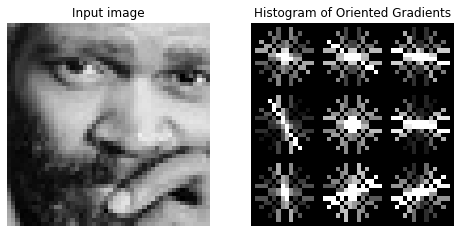

In [ ]:
#hyperparameters
shape_x = 48
shape_y = 48
ORIENTATIONS = 8
PIXES_PER_CELL = (16, 16)
CELLS_PER_BLOCK = (3, 3)

features, hog_image = hog(
    img,
    orientations = ORIENTATIONS,
    pixels_per_cell = PIXES_PER_CELL,
    cells_per_block = CELLS_PER_BLOCK,
    visualize = True
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
landmarks = np.array([x.flatten() for x in landmarks])
landmarks.shape

In [ ]:
train_hog_features = []
train_hog_images = []

for i in range(len(train_images)):
  img = train_images[i].reshape((shape_x, shape_y))
  features, hog_image = hog(
      img,
      orientations = ORIENTATIONS,
      pixels_per_cell = PIXES_PER_CELL,
      cells_per_block = CELLS_PER_BLOCK,
      visualize = True)
  train_hog_features.append(features)
  train_hog_images.append(hog_image)



In [ ]:
validation_hog_features = []
validation_hog_images = []

for i in range(len(validation_images)):
  img = validation_images[i].reshape((shape_x, shape_y))
  features, hog_image = hog(
      img,
      orientations = ORIENTATIONS,
      pixels_per_cell = PIXES_PER_CELL,
      cells_per_block = CELLS_PER_BLOCK,
      visualize = True)
  validation_hog_features.append(features)
  validation_hog_images.append(hog_image)

In [ ]:
test_hog_features = []
test_hog_images = []

for i in range(len(test_images)):
  img = test_images[i].reshape((shape_x, shape_y))
  features, hog_image = hog(
      img,
      orientations = ORIENTATIONS,
      pixels_per_cell = PIXES_PER_CELL,
      cells_per_block = CELLS_PER_BLOCK,
      visualize = True)
  test_hog_features.append(features)
  test_hog_images.append(hog_image)

In [ ]:
model = svm.SVC(decision_function_shape='ovo', random_state=42, max_iter=10000, kernel='rbf',gamma='auto')
model.fit(validation_hog_features,validation_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
    max_iter=10000, probability=False, random_state=42, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = model.predict(test_hog_features)
accuracy_hog = accuracy_score(y_pred, test_labels)
print("Accuracy : ", accuracy_hog)

Accuracy :  0.24714405126776262


In [ ]:
train_hog_features = np.load('/content/drive/MyDrive/IVC data/train_hog_features.npy')
train_labels = np.load('/content/drive/MyDrive/IVC data/train_labels.npy')
train_landmarks = np.load('/content/drive/MyDrive/IVC data/train_landmarks.npy')

test_hog_features = np.load('/content/drive/MyDrive/IVC data/test_hog_features.npy')
test_labels = np.load('/content/drive/MyDrive/IVC data/test_labels.npy')
test_landmarks = np.load('/content/drive/MyDrive/IVC data/test_landmarks.npy')

In [ ]:
X = np.hstack((train_hog_features,train_landmarks))
np.shape(X)

(28709, 208)

In [ ]:
X_test = np.hstack((test_hog_features,test_landmarks))
np.shape(X_test)

(7178, 208)

In [ ]:
model = svm.SVC(decision_function_shape='ovo', random_state=42, max_iter=10000, kernel='rbf',gamma='auto')

start_time = time()
model.fit(train_landmarks,train_labels)
training_time = time() - start_time
print("Training time : ", training_time)

# Predict
y_pred = model.predict(test_landmarks)
accuracy_landmarks = accuracy_score(y_pred, test_labels)
print("Accuracy : ", accuracy_landmarks)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Training time :  450.9948446750641
Accuracy :  0.4793814432989691


In [ ]:
model = svm.SVC(decision_function_shape='ovo', random_state=42, max_iter=10000, kernel='rbf',gamma='auto')

start_time = time()
X,y = shuffle(X,train_labels)
model.fit(X,y)
training_time = time() - start_time
print("Training time : ", training_time)

# Predict
y_pred = model.predict(X_test)
accuracy_landmarks = accuracy_score(y_pred, test_labels)
print("Accuracy : ", accuracy_landmarks)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Training time :  596.456563949585
Accuracy :  0.4896907216494845


In [ ]:
import pickle

# save
with open('/content/drive/MyDrive/IVC data/SVM.pkl','wb') as f:
    pickle.dump(model,f)

In [ ]:
with open('/content/drive/MyDrive/IVC data/SVM.pkl','rb') as f:
    model2 = pickle.load(f)

In [ ]:
model.predict([X_test[0]])

array(['happy'], dtype='<U8')